In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import data as dt


# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Debugging
## Checking the old dataset is still working

In [ ]:
dataset_folder = 'cropped_classical_tracking_dataset'
csv_path = os.path.join(dataset_folder, 'labels.csv')
image_dir = os.path.join(dataset_folder, 'frames')
quantization = 8
label_quantization = 8
trainratio, testratio, valratio = 0.9, 0.05, 0.05
labels = ['X', 'Y', 'Radius'] 
trainset = dt.Tracking3DVideoDataset(csv_path, image_dir, split='train', dataset_type="ball", augment=False, quantization=quantization, label_quantization=label_quantization, train_ratio=trainratio, test_ratio=testratio, val_ratio=valratio, labels=labels)
trainloader = DataLoader(trainset, batch_size=3, collate_fn=trainset.collate_fn, shuffle=True)
testset = dt.BallTrackingDatasetVarLenVideos(csv_path, image_dir, split='test', dataset_type="ball", augment=False, quantization=quantization, label_quantization=label_quantization, train_ratio=trainratio, test_ratio=testratio, val_ratio=valratio, labels=labels) 
testloader = DataLoader(testset, batch_size=3, collate_fn=testset.collate_fn, shuffle=False)
valset = dt.BallTrackingDatasetVarLenVideos(csv_path, image_dir, split='val', dataset_type="ball", augment=False, quantization=quantization, label_quantization=label_quantization, train_ratio=trainratio, test_ratio=testratio, val_ratio=valratio, labels=labels)
validationloader = DataLoader(valset, batch_size=3, collate_fn=valset.collate_fn, shuffle=False)

Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Found 22 sequences in cropped_classical_tracking_dataset\labels.csv
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Filtered to 14 rows for dataset type: ball
Split sizes: train=12, val=0, test=2, total=14
Final dataset split='train' size: 12
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Found 22 sequences in cropped_classical_tracking_dataset\labels.csv
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Filtered to 14 rows for dataset type: ball
Split sizes: train=12, val=0, test=2, total=14
Final dataset split='test' size: 2
Loaded 1862 rows from cropped_classical_tracking_dataset\labels.csv
Found 22 sequences in cropped_classical_tracking_dataset\labels.csv
Shape of the images: torch.Size([2, 51, 85])
Label shape: (85, 51)
Filtered to 14 rows for dataset type: ball
Split sizes: train=12, val=0, test=2, total=14
Final dataset split='val' size: 0


In [51]:
model = network.SCNNVideoClassification(trainset).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.start_training(trainloader, optimizer, device, validationloader=testloader, num_steps=10, num_epochs=30, chunk_size=10)

Flattened feature size: 3840
Number of X bins: 86
Number of Y bins: 52
Number of Radius bins: 101
Evaluating video classification tracker
All errors 3
Average Error for X: 50.8652 pixels
Average Error for Y: 4.3759 pixels
Average Error for Radius: 0.6596 pixels
Epoch 1/30, Loss: 0.5852, Validation Error: 51.0574 pixels
Evaluating video classification tracker
All errors 3
Average Error for X: 50.8652 pixels
Average Error for Y: 3.9291 pixels
Average Error for Radius: 0.6596 pixels
Epoch 2/30, Loss: 0.5708, Validation Error: 51.0210 pixels
Evaluating video classification tracker
All errors 3
Average Error for X: 50.8652 pixels
Average Error for Y: 3.9291 pixels
Average Error for Radius: 0.6596 pixels
Epoch 3/30, Loss: 0.6120, Validation Error: 51.0210 pixels
Evaluating video classification tracker
All errors 3
Average Error for X: 50.9291 pixels
Average Error for Y: 3.8227 pixels
Average Error for Radius: 0.6596 pixels
Epoch 4/30, Loss: 0.5975, Validation Error: 51.0766 pixels
Evaluating

KeyboardInterrupt: 

In [ ]:
video1, label1, length1 = testset.__getitem__(0)
preds1 = dt.get_preds_video_classification(model, video1, length1, trainset.labels, device, num_steps=12)
gen1 = dt.image_gen_for_video(video1, label1, preds1)


torch.Size([1, 86, 75])
torch.Size([1, 75])
torch.Size([1, 52, 75])
torch.Size([1, 75])
torch.Size([1, 101, 75])
torch.Size([1, 75])
(3, 75)


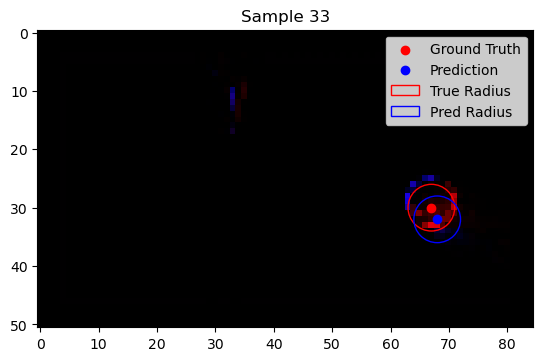

In [ ]:
dt.show_next_img_w_pred(gen1)

Old dataset is working with the current network, so the bug is not in there. The data has to be the problem

# Data Comparison

In [ ]:
# Dataset in-fov
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "all"
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='train' size: 54
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='test' size: 13
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='val' size: 11


In [339]:
video1, label1, length1 = testset.__getitem__(1)
gen1 = dt.image_gen_for_video(video1, label1)

video2, label2, length2 = testset_in.__getitem__(2)
gen2 = dt.image_gen_for_video(video2, label2)

90 160
max tensor(0.)
min tensor(0.)


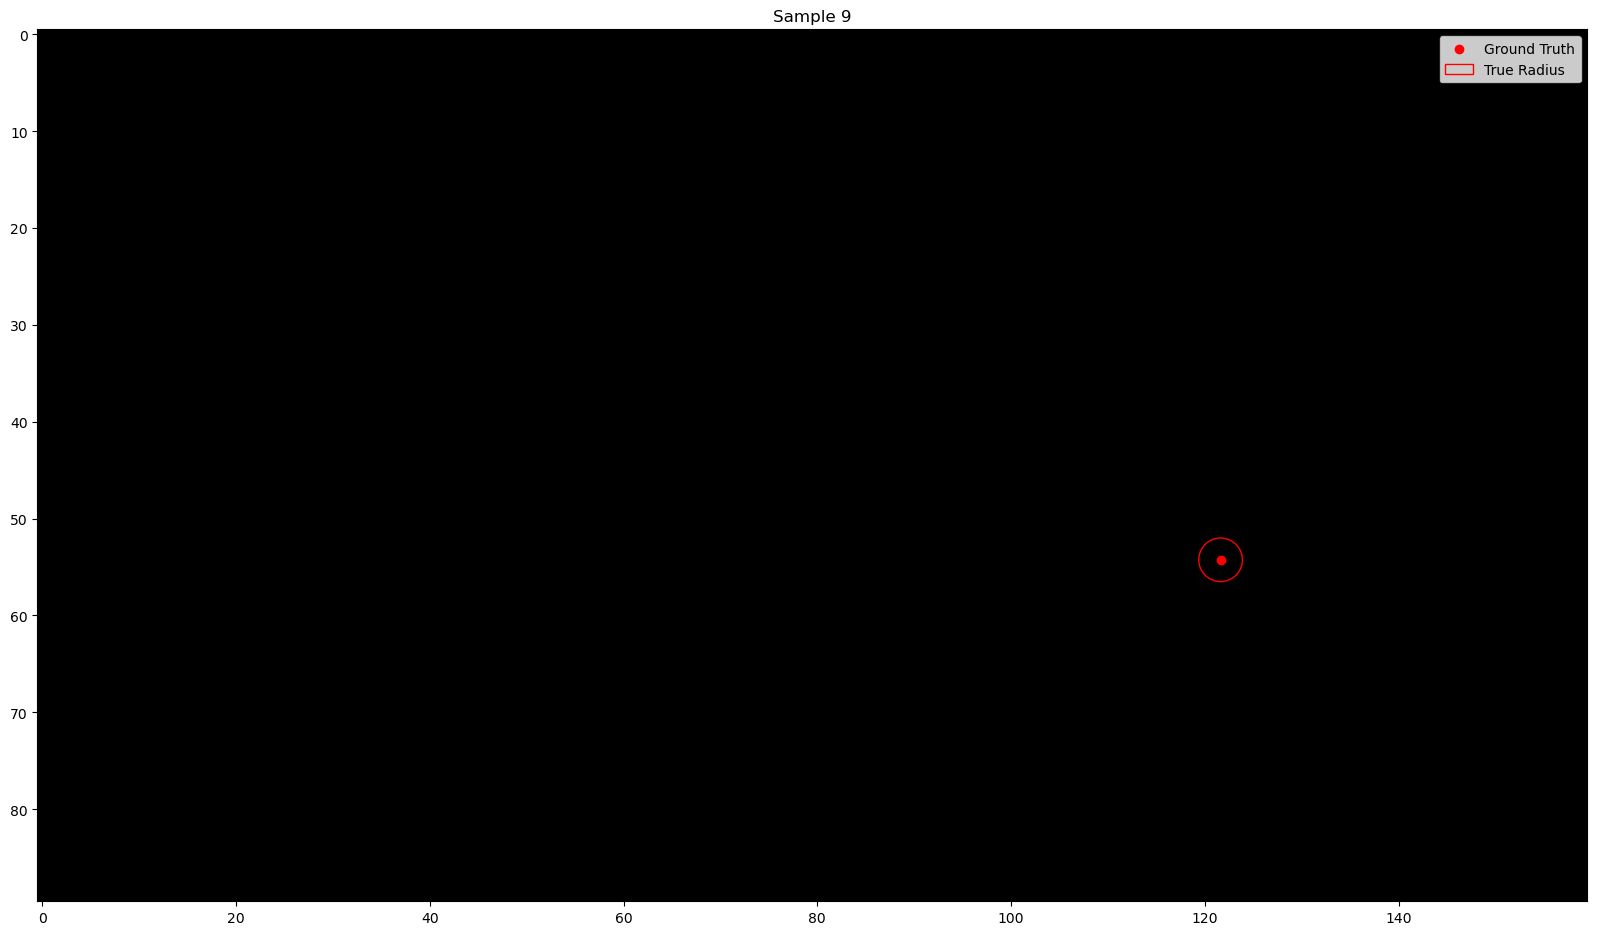

In [349]:
# dt.show_next_img(gen1)
dt.show_next_img(gen2)

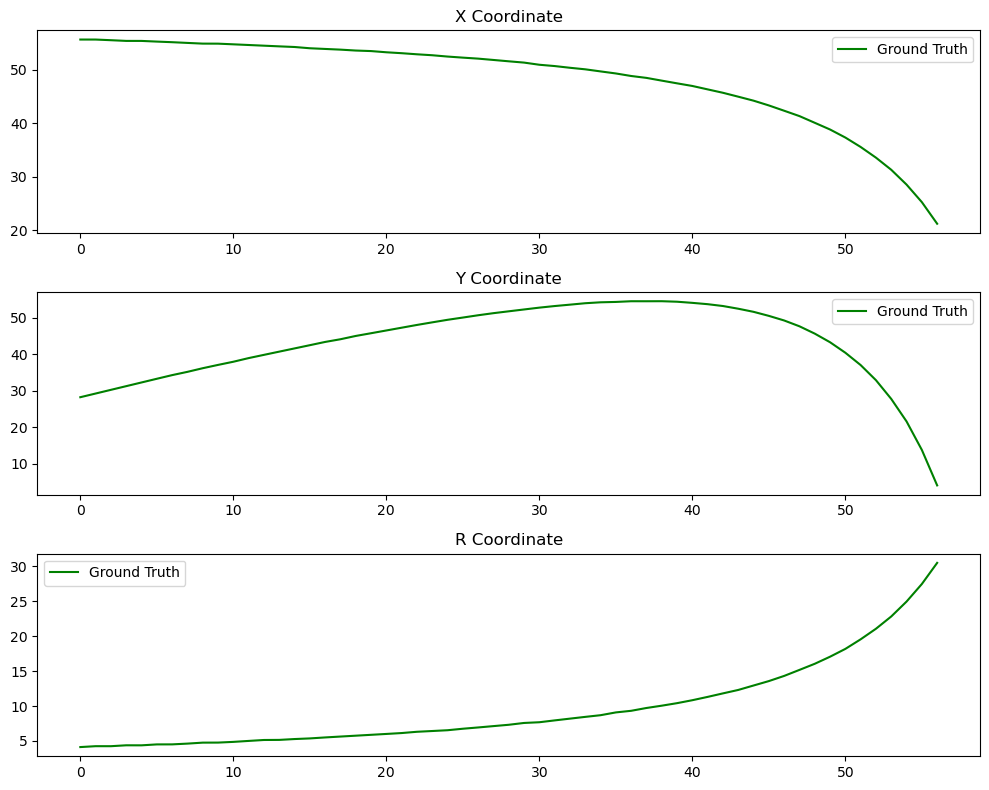

In [294]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
for i, label in enumerate(['X', 'Y', 'R']):
    axs[i].plot(label2[:, i], label='Ground Truth', color='green')
    axs[i].set_title(f'{label} Coordinate')
    axs[i].legend()
plt.tight_layout()
plt.show()

Data seems fine, but some of the rolls are too slow, thus creating too few events. 

Also, graph for quantization 8 had steps. I fixed the dataset class so it doesnt round.

Im doing two things

1. Training only on throws

If this works:

2. Creating a new dataset increasing the sensitivity and the minimum velocity for the ball

## Training only on throws in-fov

In [2]:
# Dataset in-fov
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "throws"
new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='train' size: 54
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='test' size: 13
Loaded 20632 rows from dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='val' size: 11


In [4]:
model = network.SCNNVideoClassification(trainset_in, weighted_avg=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = network.pinn_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_fn, validationloader=valid_loader_in, num_steps=10, num_epochs=50, chunk_size=40)

Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
L_phys 96.23609924316406 L_data 9357.291015625
L_phys 10430.1708984375 L_data 6214.20654296875
L_phys 29748.421875 L_data 3610.967529296875
L_phys 96.23611450195312 L_data 17468.578125
L_phys 96.2361068725586 L_data 20819.92578125
L_phys 96.23611450195312 L_data 8442.7705078125
L_phys 96.2361068725586 L_data 23345.076171875
L_phys 96.23609924316406 L_data 14756.3408203125
L_phys 29308.064453125 L_data 7919.15966796875
L_phys 96.23611450195312 L_data 13049.6025390625
L_phys 14986.849609375 L_data 11334.2109375
L_phys 919.5648193359375 L_data 13390.412109375
L_phys 96.2361068725586 L_data 16439.75
L_phys 48616.015625 L_data 13305.2431640625
L_phys 638672.125 L_data 9634.427734375
L_phys 96.23609924316406 L_data 12926.9677734375
L_phys 96.2361068725586 L_data 12050.12109375
L_phys 96.2361068725586 L_data 5562.83740234375
L_phys 96.23611450195312 L_data 12830.958984375
L_phys 96.23610

KeyboardInterrupt: 

In [456]:
network.save_model(model)

Model saved at models/VideoClassification_q8_10ts_50e.pt


In [424]:
error = model.evaluate(trainloader_in, device, num_steps=10, print_results=True)

Evaluating video classification tracker
All errors 3
Average Error for x_cam: 0.0056 pixels
Average Error for y_cam: 0.0086 pixels
Average Error for R_cam: 0.0511 pixels


In [425]:
video, label, length = validationset_in.__getitem__(0)
preds = dt.get_preds_video_classification(model, video, length, trainset_in.labels, device, num_steps=10)
gen = dt.image_gen_for_video(video, label, preds)


torch.Size([1, 161, 61])
torch.Size([1, 61])
torch.Size([1, 91, 61])
torch.Size([1, 61])
torch.Size([1, 101, 61])
torch.Size([1, 61])
(3, 61)


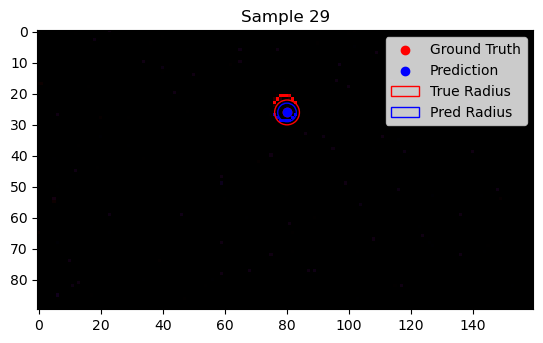

In [455]:
dt.show_next_img_w_pred(gen)

## Now Ill try with confidence

In [2]:
# Dataset in-fov
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "throws"
labels = ['x_cam', 'y_cam', 'R_cam', 'in_fov']
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='train', dataset_type=dataset_type, labels=labels)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='test', dataset_type=dataset_type, labels=labels)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='val', dataset_type=dataset_type, labels=labels)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='train' size: 54
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='test' size: 13
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Label shape: None
Split sizes: train=54, val=11, test=13, total=78
Final dataset split='val' size: 11


In [ ]:
model = network.SCNNVideoClassification(trainset).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = network.classification_loss_w_confidence
model.start_training(trainloader, optimizer, device, loss_function=loss_fn, validationloader=validationloader, num_steps=10, num_epochs=50, chunk_size=40)

Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Number of in_fov bins: 1
Evaluating video classification tracker
All errors 4
Average Error for x_cam: 37.5553 pixels
Average Error for y_cam: 34.4885 pixels
Average Error for R_cam: 2.9248 pixels
Average Error for in_fov: 0.9708 pixels
Epoch 1/50, Loss: 0.1955, Validation Error: 51.0819 pixels
Evaluating video classification tracker
All errors 4
Average Error for x_cam: 19.1858 pixels
Average Error for y_cam: 32.2004 pixels
Average Error for R_cam: 5.7745 pixels
Average Error for in_fov: 0.9708 pixels
Epoch 2/50, Loss: 0.1902, Validation Error: 37.9374 pixels
Evaluating video classification tracker
All errors 4
Average Error for x_cam: 9.6785 pixels
Average Error for y_cam: 11.5282 pixels
Average Error for R_cam: 10.5073 pixels
Average Error for in_fov: 0.9708 pixels
Epoch 3/50, Loss: 0.1711, Validation Error: 18.3826 pixels
Evaluating video classification tracker
All errors 4
Av

KeyboardInterrupt: 

Things to try

- PINN loss with just the parabolic part
- Confidence
- Fix error distribution function
- Trained model with KF


## Pinn loss on trained model

In [5]:
model = network.load_model('models/VideoClassification_q8_10ts_50e.pt', network.SCNNVideoClassification, trainset_in, device)

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:1809: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


In [8]:
model.evaluate(valid_loader_in, device, num_steps=10, print_results=True, weighted_avg=False)

Evaluating video classification tracker
All errors 3
Average Error for x_cam: 2.2804 pixels
Average Error for y_cam: 2.1854 pixels
Average Error for R_cam: 2.0442 pixels


array([2.2803532 , 2.18543046, 2.04415011])

In [9]:
model.evaluate(valid_loader_in, device, num_steps=10, print_results=True, weighted_avg=True)

Evaluating video regression tracker
Average Error for x_cam: 1.9244 pixels
Average Error for y_cam: 1.9244 pixels
Average Error for R_cam: 1.9244 pixels


array([1.9244379, 1.9244379, 1.9244379], dtype=float32)

L_phys 20021399414374.402 L_data 18877.068359375
L_phys 23241057894.4 L_data 10942.56640625
L_phys 21970103251763.203 L_data 17012.458984375
L_phys 3091883832115.2 L_data 8710.8623046875
L_phys 114943872.0 L_data 8415.58203125
L_phys 17482159384166.4 L_data 9983.3583984375
L_phys 537272202035.2 L_data 17240.361328125
L_phys 5424707692134.4 L_data 12946.2294921875
L_phys 8872941898956.8 L_data 8039.1279296875
L_phys 1012778139648.0 L_data 3825.263427734375
L_phys 1350158411366.4001 L_data 9724.8916015625
L_phys 126565259673.6 L_data 11232.74609375
L_phys 6924357179801.601 L_data 9825.4248046875
L_phys 1102437783961.6 L_data 17773.083984375
L_phys 1298589758259.2 L_data 10617.548828125
L_phys 188693348352.0 L_data 5332.01904296875
L_phys 10454341307596.8 L_data 12855.4365234375
L_phys 4547588548198.4 L_data 7718.630859375
L_phys 180380853862.40002 L_data 8614.4580078125
L_phys 33348864127795.203 L_data 13923.337890625
L_phys 1960216992153.6 L_data 11482.0546875
L_phys 13906520257331.201 

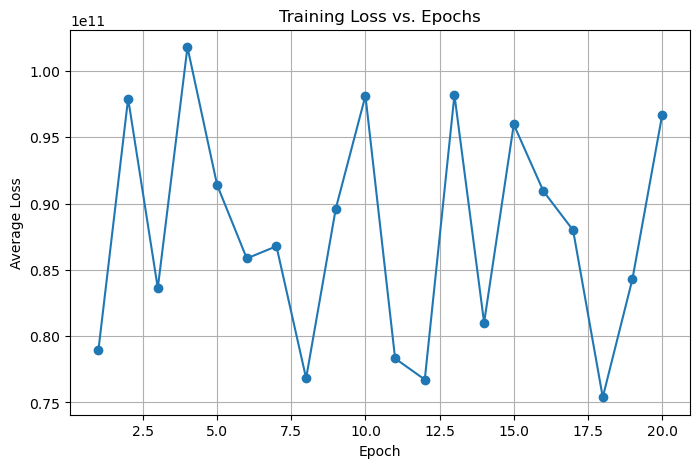

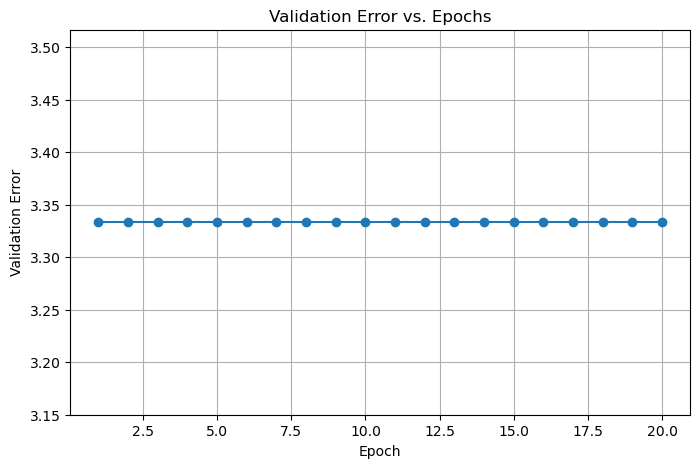

In [10]:
model.weighted_avg = True
loss_fn = network.pinn_loss
model.start_training(trainloader_in, optimizer, device, loss_function=loss_fn, validationloader=valid_loader_in, num_steps=10, num_epochs=20, chunk_size=40)